#Description
    Demultiplex RhizCG 150615_run2


#Setting variables

In [45]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150615_run2/'
seqDir = '/var/seq_data/RhizCG/150615_run2/raw/'

metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_run2.txt'
read1_file = 'read1.fq'
read2_file = 'read2.fq'
index_read1_file = 'Undetermined_S0_L001_I1_001.fastq'
index_read2_file = 'Undetermined_S0_L001_I2_001.fastq'
read12_screed_file = 'pear_merged-2015-06-18.assembled.fastq_screed'

#Init

In [46]:
import os
import screed
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from ggplot import *
import re
import scipy.stats as stats

In [47]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [48]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [49]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gdata)

In [50]:
#!cd $seqDir; \
 #   pigz -k -d -p 24 Undetermined_S0_L001_I?_001.fastq.gz

Undetermined_S0_L001_I1_001.fastq exists -- overwrite (y/n)? ^C


In [9]:
#long processessing time
os.chdir(seqDir)
screed.read_fastq_sequences(index_read1_file)
screed.read_fastq_sequences(index_read2_file)

<ScreedDB, 'Undetermined_S0_L001_I2_001.fastq_screed'>

##Checkpoint: define index screed files to skip above step

In [55]:
os.chdir(seqDir)
index_read1_screed = index_read1_file + '_screed'
index_read2_screed = index_read2_file + '_screed'

#Demultiplex

In [56]:
# rev-comp functions
def complement(seq): 
    idx = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N'} 
    idx.update( {x.lower():y.lower() for x,y in idx.items()} )
    return ''.join(idx[x] for x in list(seq))

def revComp(seq):
    seq = seq[::-1]
    return complement(seq)

In [63]:
# loading/editing metadata

df_meta = pd.read_table(os.path.join(workDir,metadataFile), delimiter="\t")
df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])

df_meta['Barcode_FR'] = [(revComp(y) + x).lower() for x,y \
                         in zip(df_meta.fwd_barcode,df_meta.rev_barcode)]

## format of barcode=>sample dict: [revcomp(revBarcode=read1) + fwdBarcode=read2] : sampleID
map_d = {x:y for x,y in zip(df_meta.Barcode_FR, df_meta.Sample)}

In [64]:
# loading screed databases 
os.chdir(seqDir)

ir1db = screed.ScreedDB(index_read1_screed)
ir2db = screed.ScreedDB(index_read2_screed)
amp_db = screed.ScreedDB(read12_screed_file)

In [65]:
# demultiplexing: naming reads by sample

outFile = re.sub('fastq_screed', 'dmult.fastq', read12_screed_file)

counter = 0
unassigned = 0
cnt = Counter()
outFile = os.path.join(workDir, outFile)
c = 0
with open(outFile, "w") as out:
    for rec in amp_db.itervalues():
        # debug
        #c += 1
        #if c > 10000:
        #    break
            
        index_concat = ir1db[rec["name"]]["sequence"] + ir2db[rec["name"]]["sequence"]
        
        try:
            new_name = map_d[index_concat.lower()] + "_" + str(counter) #case sensitive
        except KeyError:
            unassigned += 1
            continue
        counter += 1
        cnt[map_d[index_concat.lower()]] += 1 #case sensitive
        s, q = rec["sequence"], rec["accuracy"]
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        
        
print "Unable to assign %s reads to samples"%unassigned

Unable to assign 1740885 reads to samples


In [66]:
print outFile

/home/bryan/RhizCG/data/MiSeq_amplicon/150615_run2/pear_merged-2015-06-18.assembled.dmult.fastq


##Checkpoint: define outfile for next command without running above.

In [ ]:
outFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/150615_run2/pear_merged-2015-06-18.assembled.dmult.fastq'

In [67]:
# number of sequences
n_lines = !wc -l $outFile
n_lines = int(re.sub(' .+', '', n_lines[0]))
print 'Number of sequences: {}'.format(n_lines/4)

Number of sequences: 2905476


# Stats on sequences

## Number of sequences per sample

In [68]:
# counting sequences for each sample
re_seqName = re.compile(r'_\d+ orig_name.+')

seq_cnt = dict()
with open(outFile, 'r') as fn:
    for line in fn.readlines():
        if re.search(re_seqName, line):
            sampleName = re.sub(re_seqName, '', line).rstrip().lstrip('@')
            try:
                seq_cnt[sampleName] += 1
            except KeyError:
                seq_cnt[sampleName] = 1 

In [69]:
# converting to dataframe
df_seq_cnt = pd.DataFrame(seq_cnt.items(), columns=['Sample', 'seq_count'])
df_seq_cnt

,Sample,seq_count
0,sample8-3.28_Nneg,13957
1,sample8-1.06_Nneg,14409
2,sample6-4.13_Npos,14649
3,sample7-1.28_Npos,41917
4,sample6-2.05_Npos,36630
5,sample8-1.10_Nneg,32306
6,sample7-3.19_Nneg,39622
7,sample8-1.14_Nneg,52448
8,sample7-3.12_Nneg,12807
9,sample8-2.17_Npos,22881


In [70]:
%%R -i workDir -i metadataFile -i df_seq_cnt

myDir = paste(c(workDir, '../'), collapse='')
setwd(myDir)


df_meta = read.delim(metadataFile)
df_meta %>% head %>% print

           X..sample Library Sample_Number Sample_Well_ID Primer_Number
1          Mock_comm       2            93            F12            93
2      Neg_Control_1       2            91            G12            91
3 Negative_Control_2       2            16            D11            16
4        Pos_Control       2            92            H12            92
5      Pos_Control_2       2            17            D12            17
6  sample1-1.06_Nneg       2             4             D1             4
  Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
1            F12                  94                94         94      <NA>
2            G12                  95                95         95      <NA>
3            D11                  84               180        180      <NA>
4            H12                  96                96         96      <NA>
5            D12                  92               188        188      <NA>
6             D1                   4    

In [71]:
%%R

tbl.cnt = inner_join(df_seq_cnt, df_meta, c('Sample' = 'X..sample'))
tbl.cnt %>% head

             Sample seq_count Library Sample_Number Sample_Well_ID
1 sample8-3.28_Nneg     13957       2            12            E10
2 sample8-1.06_Nneg     14409       2            46             A7
3 sample6-4.13_Npos     14649       2            69             H9
4 sample7-1.28_Npos     41917       2            15             G2
5 sample6-2.05_Npos     36630       2             6             F1
6 sample8-1.10_Nneg     32306       2            78            A11
  Primer_Number Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total barcode_ID
1            12             E2                  13               109        109
2            46             A7                  49                49         49
3            69             H9                  72                72         72
4            15             G2                  15                15         15
5             6             F1                   6                 6          6
6            78            A11                  81 

In [72]:
%%R

tbl.cnt[,1] %>% print


  [1] sample8-3.28_Nneg  sample8-1.06_Nneg  sample6-4.13_Npos 
  [4] sample7-1.28_Npos  sample6-2.05_Npos  sample8-1.10_Nneg 
  [7] sample7-3.19_Nneg  sample8-1.14_Nneg  sample7-3.12_Nneg 
 [10] sample8-2.17_Npos  Pos_Control_2      sample6-4.13_Nneg 
 [13] sample7-2.12_Npos  sample8-1.19_Nneg  sample6-2.14_Nneg 
 [16] sample8-2.07_Npos  sample6-2.14_Npos  sample8-3.29_Nneg 
 [19] sample8-3.23_Nneg  sample8-3.29_Npos  sample3-3.30_Npos 
 [22] sample7-2.05_Nneg  sample7-1.28_Nneg  sample8-1.06_Npos 
 [25] sample8-4.04_Npos  sample7-2.28_Npos  sample3-4.18_Nneg 
 [28] sample2-2.10_Npos  sample8-1.23_Npos  sample7-4.02_Nneg 
 [31] sample8-2.25_Npos  sample7-1.06_Npos  sample2-3.20_Nneg 
 [34] sample8-3.03_Nneg  sample2-4.16_Nneg  sample8-3.07_Nneg 
 [37] sample2-4.16_Npos  sample8-1.19_Npos  sample8-1.23_Nneg 
 [40] sample8-2.22_Nneg  sample6-1.18_Nneg  sample8-4.01_Nneg 
 [43] sample7-2.30_Npos  sample3-4.27_Npos  sample4-1.06_Npos 
 [46] sample7-1.04_Npos  sample7-4.27_Nneg  sample7-4.0

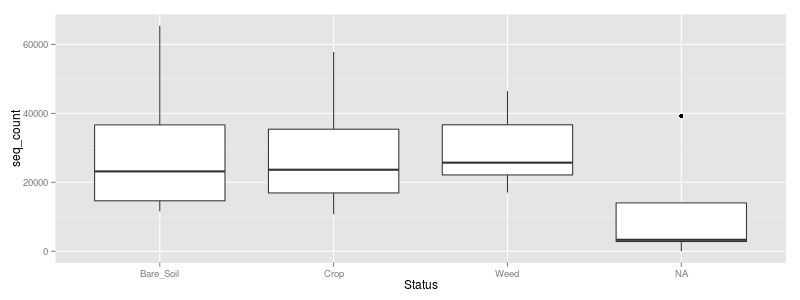

In [73]:
%%R -w 800 -h 300


ggplot(tbl.cnt, aes(Status, seq_count)) +
    geom_boxplot()